# Combining recency and similarity

<div class="alert alert-block alert-warning">
Replace <code>YOUR_GITHUB_TOKEN</code> in the install script. To get your token follow the instructions in the <a href="../README.md">README.md</a>
</div>

In [1]:
%pip install  'https://us-central1-data-359211.cloudfunctions.net/github-proxy/superlinked-2.2.0-py3-none-any.whl?token=YOUR_GITHUB_TOKEN'

In addition to being able to use different spaces to embed your data, you can also combine signals from different models to a single index. This allows you to dynamically change the weight of these embeding at query time.

In [2]:
import altair as alt
alt.renderers.enable('mimetype')
import time
import pandas as pd

from superlinked.evaluation.charts.recency_plotter import RecencyPlotter
from superlinked.framework.common.schema.schema import schema
from superlinked.framework.common.schema.schema_object import String, Timestamp
from superlinked.framework.dsl.executor.in_memory.in_memory_executor import InMemoryExecutor
from superlinked.framework.dsl.index.index import Index
from superlinked.framework.dsl.query.param import Param
from superlinked.framework.dsl.query.query import Query
from superlinked.framework.dsl.source.in_memory_source import InMemorySource
from superlinked.framework.dsl.space.recency_space import RecencySpace
from superlinked.framework.dsl.space.text_similarity_space import TextSimilaritySpace

@schema
class Paragraph:
    body: String
    created_at: Timestamp


paragraph = Paragraph()

relevance_space = TextSimilaritySpace(text=paragraph.body, model="all-MiniLM-L6-v2")
recency_space = RecencySpace(timestamp=paragraph.created_at)
paragraph_index = Index([relevance_space, recency_space])

In order to grasp how recency work, we can plot the curve. It shows the recency score of objects based on their creation date

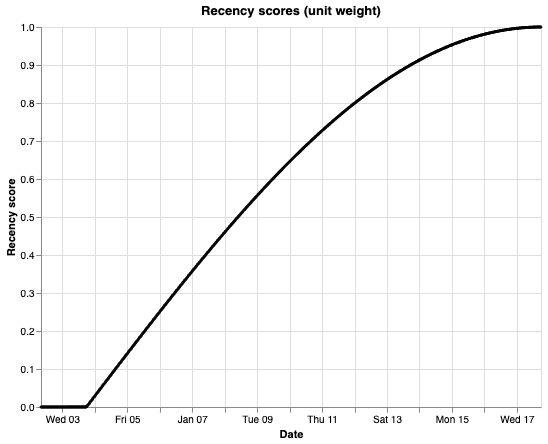

In [3]:
recency_plotter = RecencyPlotter(recency_space)
chart = recency_plotter.plot_recency_curve()
chart

In [4]:
source: InMemorySource = InMemorySource(paragraph)
executor = InMemoryExecutor(sources=[source], indices=[paragraph_index])
app = executor.run()

NOW = int(time.time())
WEEK_AGO = NOW - 60 * 60 * 24 * 7

source.put([{"id": "recent_and_relevant", "body": "Let's talk physics.", "created_at": NOW}])
source.put(
    [
        {
            "id": "recent_but_not_relevant",
            "body": "Bananas.",
            "created_at": NOW,
        }
    ]
)
source.put(
    [{"id": "old_and_relevant", "body": "Let's talk biology.", "created_at": WEEK_AGO}]
)
source.put(
    [{"id": "old_and_not_relevant", "body": "Stone.", "created_at": WEEK_AGO}]
)

query = (
    Query(
        paragraph_index,
        weights={
            relevance_space: Param("relevance_weight"),
            recency_space: Param("recency_weight"),
        },
    )
    .find(paragraph)
    .similar(relevance_space.text, Param("query_text"))
)

Compare the results biased to relevance.

In [5]:
result = app.query(
    query,
    query_text="I am interested in science articles.",
    relevance_weight=1,
    recency_weight=0.1,
)

pd.DataFrame([entry.stored_object for entry in result.entries])

,body,created_at,id
0,Let's talk biology.,1704905396,old_and_relevant
1,Let's talk physics.,1705510196,recent_and_relevant
2,Bananas.,1705510196,recent_but_not_relevant
3,Stone.,1704905396,old_and_not_relevant


Check results biased to recency.

In [6]:
result = app.query(
    query,
    query_text="I am interested in science articles.",
    relevance_weight=1,
    recency_weight=2,
)

pd.DataFrame([entry.stored_object for entry in result.entries])

,body,created_at,id
0,Let's talk physics.,1705510196,recent_and_relevant
1,Bananas.,1705510196,recent_but_not_relevant
2,Let's talk biology.,1704905396,old_and_relevant
3,Stone.,1704905396,old_and_not_relevant
